We will use the starter notebook to the Kaggle Competition as reference for our initial implementation

# Import Libraries

In [1]:
import os
print(os.getcwd())

/Users/visheshgoyal/Desktop/DS301/Project


In [2]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"  # "jax" or "tensorflow" or "torch"

import keras_cv
import keras
import keras.backend as K
import tensorflow as tf
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
import librosa
import IPython.display as ipd
import librosa.display as lid
import matplotlib.pyplot as plt
import matplotlib as mpl
cmap = mpl.cm.get_cmap('coolwarm')

/var/folders/x7/ywj4w0wn5x70b0g0cw1l_29r0000gn/T/ipykernel_57318/3701191668.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('coolwarm')


In [3]:
import tensorflow as tf

# List all GPUs and enable memory growth for each GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth enabled; dynamic GPU memory allocation requested.")
    except RuntimeError as e:
        print("Error enabling memory growth:", e)


## Library Version

In [4]:
import keras_cv
import keras
import keras.backend as K
import tensorflow as tf

print("TensorFlow:", tf.__version__)
print("Keras:", keras.__version__)
print("KerasCV:", keras_cv.__version__)


TensorFlow: 2.18.0
Keras: 3.6.0
KerasCV: 0.9.0


# Configuration

You will need to change the paths to your local directories

In [5]:
class CFG:
    seed = 42

    # Input image size and batch size
    img_size = [128, 384]
    batch_size = 64

    # Audio duration, sample rate, and length
    duration = 15 # second
    sample_rate = 32000
    audio_len = duration*sample_rate

    # STFT parameters
    nfft = 2028
    window = 2048
    hop_length = audio_len // (img_size[1] - 1)
    fmin = 20
    fmax = 16000

    # Number of epochs, model name
    epochs = 10
    preset =  "efficientnetv2_b0_imagenet"

    # Data augmentation parameters
    augment=True

    # Class Labels for BirdCLEF 24
    #class_names = sorted(os.listdir("birdclef-2024/train_audio")) # Change this  path
    class_names = sorted([
        folder for folder in os.listdir("birdclef-2024/train_audio") 
        if os.path.isdir(os.path.join("birdclef-2024/train_audio", folder)) and not folder.startswith('.')
    ])
    num_classes = len(class_names)
    class_labels = list(range(num_classes))
    label2name = dict(zip(class_labels, class_names))
    name2label = {v:k for k,v in label2name.items()}

# Dataset Path

In [6]:
BASE_PATH = "birdclef-2024"

In [7]:
df = pd.read_csv(f'{BASE_PATH}/train_metadata.csv')
df['filepath'] = BASE_PATH + '/train_audio/' + df.filename
df['target'] = df.primary_label.map(CFG.name2label)
df['filename'] = df.filepath.map(lambda x: x.split('/')[-1])
df['xc_id'] = df.filepath.map(lambda x: x.split('/')[-1].split('.')[0])

# Display rwos
df.head(2)

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename,filepath,target,xc_id
0,asbfly,[],['call'],39.2297,118.1987,Muscicapa dauurica,Asian Brown Flycatcher,Matt Slaymaker,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://www.xeno-canto.org/134896,XC134896.ogg,birdclef-2024/train_audio/asbfly/XC134896.ogg,0,XC134896
1,asbfly,[],['song'],51.4030,104.6401,Muscicapa dauurica,Asian Brown Flycatcher,Magnus Hellström,Creative Commons Attribution-NonCommercial-Sha...,2.5,https://www.xeno-canto.org/164848,XC164848.ogg,birdclef-2024/train_audio/asbfly/XC164848.ogg,0,XC164848


## Utility

In [8]:
def load_audio(filepath):
    audio, sr = librosa.load(filepath)
    return audio, sr

def get_spectrogram(audio):
    spec = librosa.feature.melspectrogram(y=audio,
                                   sr=CFG.sample_rate,
                                   n_mels=256,
                                   n_fft=2048,
                                   hop_length=512,
                                   fmax=CFG.fmax,
                                   fmin=CFG.fmin,
                                   )
    spec = librosa.power_to_db(spec, ref=1.0)
    min_ = spec.min()
    max_ = spec.max()
    if max_ != min_:
        spec = (spec - min_)/(max_ - min_)
    return spec

def display_audio(row):
    caption = f'Id: {row.filename} | Name: {row.common_name} | Sci.Name: {row.scientific_name} | Rating: {row.rating}'
    audio, sr = load_audio(row.filepath)
    # Keep fixed length audio
    audio = audio[:CFG.audio_len]
    # Spectrogram from audio
    spec = get_spectrogram(audio)
    # Display audio
    print("# Audio:")
    display(ipd.Audio(audio, rate=CFG.sample_rate))
    print('# Visualization:')
    fig, ax = plt.subplots(2, 1, figsize=(12, 2*3), sharex=True, tight_layout=True)
    fig.suptitle(caption)
    # Waveplot
    lid.waveshow(audio,
                 sr=CFG.sample_rate,
                 ax=ax[0],
                 color= cmap(0.1))
    # Specplot
    lid.specshow(spec,
                 sr = CFG.sample_rate,
                 hop_length=512,
                 n_fft=2048,
                 fmin=CFG.fmin,
                 fmax=CFG.fmax,
                 x_axis = 'time',
                 y_axis = 'mel',
                 cmap = 'coolwarm',
                 ax=ax[1])
    ax[0].set_xlabel('');
    fig.show()

## Sample 1

# Audio:


# Visualization:


/var/folders/x7/ywj4w0wn5x70b0g0cw1l_29r0000gn/T/ipykernel_57318/3319581658.py:51: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


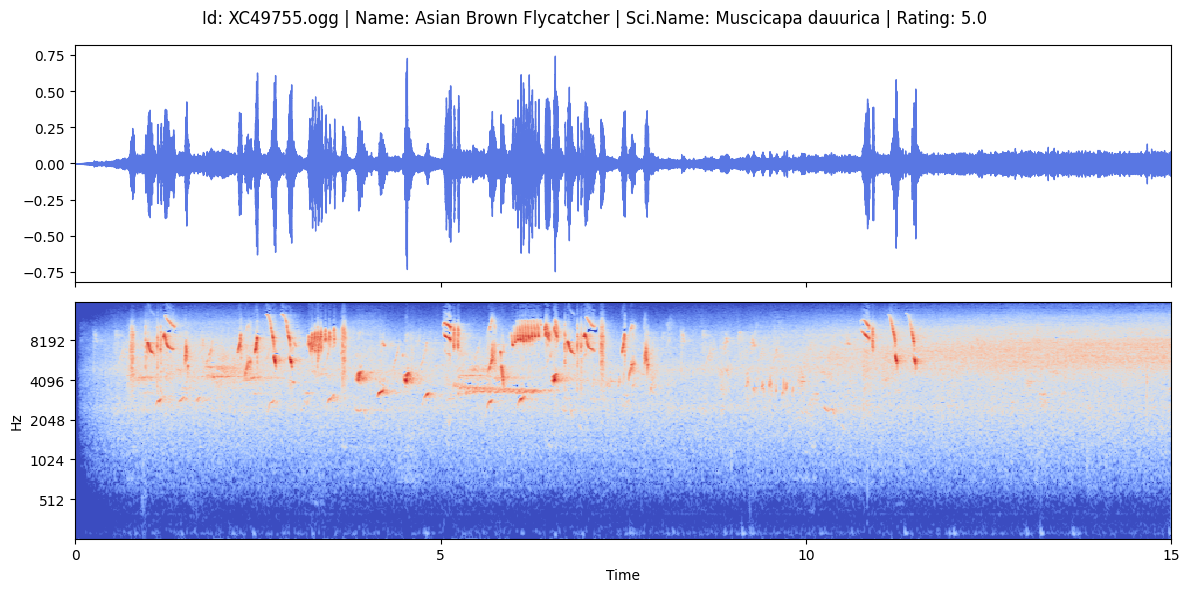

In [9]:
row = df.iloc[35]

# Display audio
display_audio(row)

# Data Split  

Since we do not have access to the testing set, we will split training into two and treat validation set as test set initially

In [10]:
# Import required packages
from sklearn.model_selection import train_test_split

train_df, valid_df = train_test_split(df, test_size=0.2)

print(f"Num Train: {len(train_df)} | Num Valid: {len(valid_df)}")

Num Train: 19567 | Num Valid: 4892


# Data Loader

## Decoders

Here, we will take inspiration from other previous implementation regarding decoding .ogg files as they are good practices. For example, we will change from stereo to mono and standardize the length as well as generate mel spectograms with 3 channels to match ImageNet. Decoding is done using librosa package.


In [11]:
import librosa
import tensorflow as tf

def build_decoder(with_labels=True, dim=1024):
    def get_audio(filepath):
        def _load_audio(path):
            # Convert the path tensor to a string
            path = tf.compat.as_str_any(path.numpy())
            # Load the audio file with librosa
            audio, _ = librosa.load(path, sr=CFG.sample_rate, mono=True)
            return audio

        # Use tf.py_function to execute _load_audio in eager mode
        audio = tf.py_function(_load_audio, [filepath], tf.float32)
        return tf.reshape(audio, [-1])  # Ensure it has a 1D shape

    def crop_or_pad(audio, target_len, pad_mode="constant"):
        audio_len = tf.shape(audio)[0]
        diff_len = abs(target_len - audio_len)
        if audio_len < target_len:
            pad1 = tf.random.uniform([], maxval=diff_len, dtype=tf.int32)
            pad2 = diff_len - pad1
            audio = tf.pad(audio, paddings=[[pad1, pad2]], mode=pad_mode)
        elif audio_len > target_len:
            idx = tf.random.uniform([], maxval=diff_len, dtype=tf.int32)
            audio = audio[idx : (idx + target_len)]
        return tf.reshape(audio, [target_len])

    def apply_preproc(spec):
        mean = tf.math.reduce_mean(spec)
        std = tf.math.reduce_std(spec)
        spec = tf.where(tf.math.equal(std, 0), spec - mean, (spec - mean) / std)

        min_val = tf.math.reduce_min(spec)
        max_val = tf.math.reduce_max(spec)
        spec = tf.where(
            tf.math.equal(max_val - min_val, 0),
            spec - min_val,
            (spec - min_val) / (max_val - min_val),
        )
        return spec

    def get_target(target):
        target = tf.reshape(target, [1])
        target = tf.cast(tf.one_hot(target, CFG.num_classes), tf.float32)
        target = tf.reshape(target, [CFG.num_classes])
        return target

    def decode(path):
        audio = get_audio(path)
        audio = crop_or_pad(audio, dim)

        # Compute Mel spectrogram with librosa
        def _compute_mel_spec(audio):
            mel_spec = librosa.feature.melspectrogram(
                y=audio.numpy(),
                sr=CFG.sample_rate,
                n_fft=CFG.nfft,
                hop_length=CFG.hop_length,
                n_mels=CFG.img_size[0]
            )
            mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
            return mel_spec

        mel_spec = tf.py_function(_compute_mel_spec, [audio], tf.float32)
        mel_spec = apply_preproc(mel_spec)
        mel_spec = tf.tile(mel_spec[..., None], [1, 1, 3])
        mel_spec = tf.image.resize(mel_spec, CFG.img_size)
        return mel_spec

    def decode_with_labels(path, label):
        label = get_target(label)
        return decode(path), label

    return decode_with_labels if with_labels else decode


## Augmenters
We will apply augmentations to spectrogram data by usingMixUp, CutOut (TimeMasking and FreqMasking in this case) from KerasCV for this initial implementation. We plan to experiment with other augmentation techniques later in the project but from looking at related work regarding CNNs, these seems to work the best and will be a good initial starting point to expriment with.

In [12]:
def build_augmenter():
    augmenters = [
        keras_cv.layers.MixUp(alpha=0.4),
        keras_cv.layers.RandomCutout(height_factor=(1.0, 1.0),
                                     width_factor=(0.06, 0.12)), # time-masking
        keras_cv.layers.RandomCutout(height_factor=(0.06, 0.1),
                                     width_factor=(1.0, 1.0)), # freq-masking
    ]

    def augment(img, label):
        data = {"images":img, "labels":label}
        for augmenter in augmenters:
            if tf.random.uniform([]) < 0.35:
                data = augmenter(data, training=True)
        return data["images"], data["labels"]

    return augment

## Data Pipeline
We will use the tf.dataset package to build a datapipeline incorporating different paths to the audio files

In [13]:
def build_dataset(paths, labels=None, batch_size=32,
                  decode_fn=None, augment_fn=None, cache=True,
                  augment=False, shuffle=2048):

    if decode_fn is None:
        decode_fn = build_decoder(labels is not None, dim=CFG.audio_len)

    if augment_fn is None:
        augment_fn = build_augmenter()

    AUTO = tf.data.experimental.AUTOTUNE
    slices = (paths,) if labels is None else (paths, labels)
    ds = tf.data.Dataset.from_tensor_slices(slices)
    ds = ds.map(decode_fn, num_parallel_calls=AUTO)
    ds = ds.cache() if cache else ds
    if shuffle:
        opt = tf.data.Options()
        ds = ds.shuffle(shuffle, seed=CFG.seed)
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
    ds = ds.batch(batch_size, drop_remainder=True)
    ds = ds.map(augment_fn, num_parallel_calls=AUTO) if augment else ds
    ds = ds.prefetch(AUTO)
    return ds

## Build Train and Valid Datasets

In [14]:
# Train
train_paths = train_df.filepath.values
train_labels = train_df.target.values
train_ds = build_dataset(train_paths, train_labels, batch_size=CFG.batch_size,
                         shuffle=True, augment=CFG.augment)

# Valid
valid_paths = valid_df.filepath.values
valid_labels = valid_df.target.values
valid_ds = build_dataset(valid_paths, valid_labels, batch_size=CFG.batch_size,
                         shuffle=False, augment=False)

In [43]:
print(type(valid_ds))
print(len(valid_ds))

<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>
76


In [41]:
print(type(valid_paths))
print(type(valid_labels))
print(valid_paths)
print(valid_labels)
print(len(valid_labels))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
['birdclef-2024/train_audio/rorpar/XC561984.ogg'
 'birdclef-2024/train_audio/blrwar1/XC659129.ogg'
 'birdclef-2024/train_audio/whbwag1/XC267085.ogg' ...
 'birdclef-2024/train_audio/junowl1/XC308275.ogg'
 'birdclef-2024/train_audio/grtdro1/XC576681.ogg'
 'birdclef-2024/train_audio/comkin1/XC677956.ogg']
[143  20 170 ...  97  73  39]
4892


# Visualization
Generate **spectrogram** and its associate **label**

In [15]:
def plot_batch(batch, row=3, col=3, label2name=None,):
    """Plot one batch data"""
    if isinstance(batch, tuple) or isinstance(batch, list):
        specs, tars = batch
    else:
        specs = batch
        tars = None
    plt.figure(figsize=(col*5, row*3))
    for idx in range(row*col):
        ax = plt.subplot(row, col, idx+1)
        lid.specshow(np.array(specs[idx, ..., 0]),
                     n_fft=CFG.nfft,
                     hop_length=CFG.hop_length,
                     sr=CFG.sample_rate,
                     x_axis='time',
                     y_axis='mel',
                     cmap='coolwarm')
        if tars is not None:
            label = tars[idx].numpy().argmax()
            name = label2name[label]
            plt.title(name)
    plt.tight_layout()
    plt.show()

2024-12-13 00:45:45.114482: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


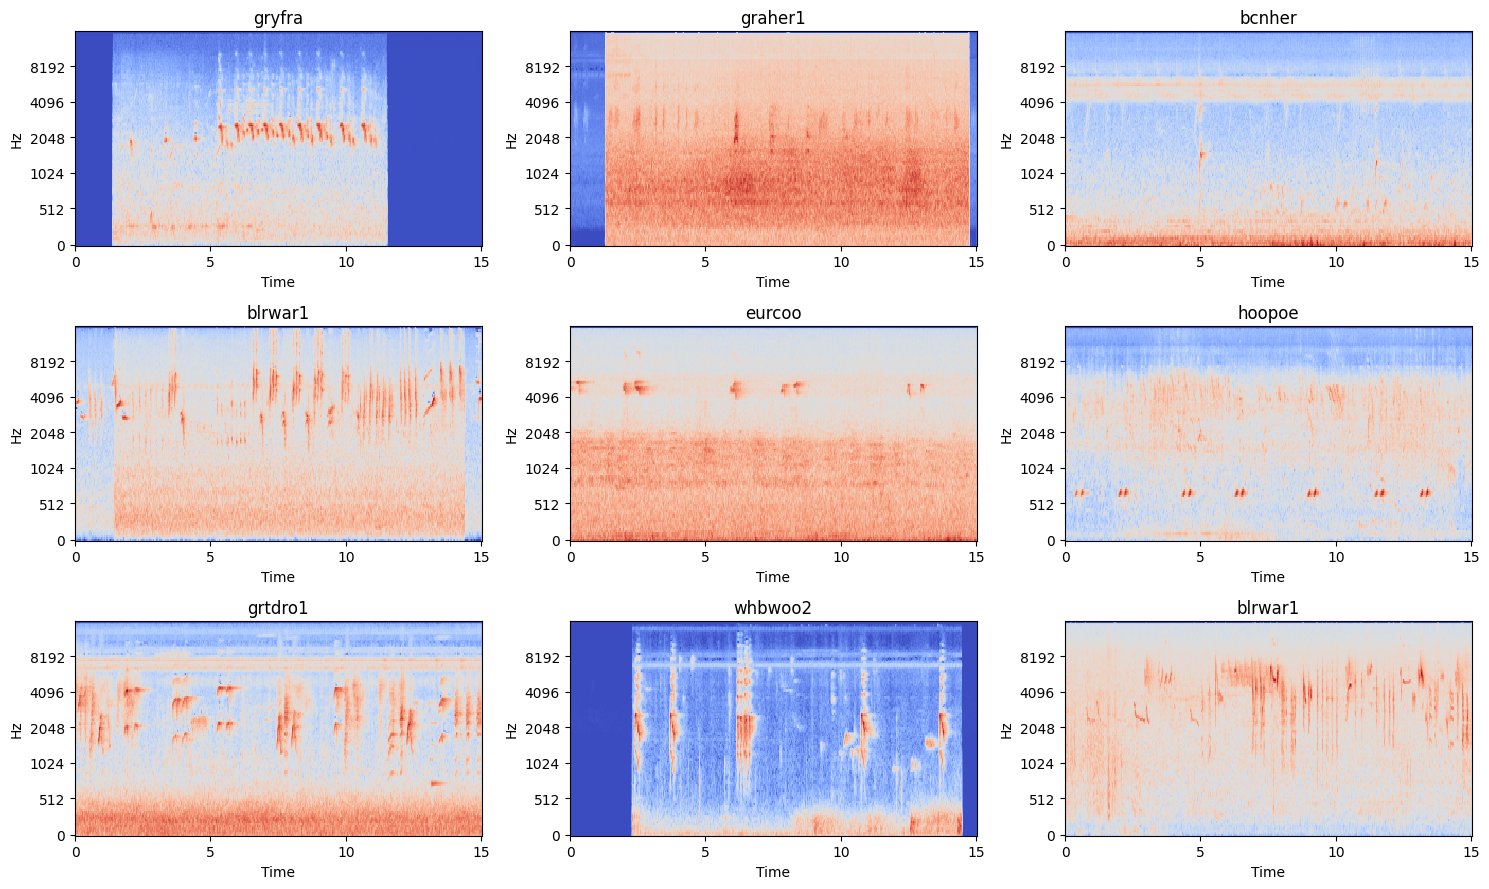

In [16]:
sample_ds = train_ds.take(100)
batch = next(iter(sample_ds))
plot_batch(batch, label2name=CFG.label2name)

In [17]:
print(keras_cv.models.EfficientNetV2Backbone.presets)

{'efficientnetv2_s': {'metadata': {'description': 'EfficientNet architecture with 6 convolutional blocks.', 'params': 20331360, 'official_name': 'EfficientNetV2', 'path': 'efficientnetv2'}, 'kaggle_handle': 'kaggle://keras/efficientnetv2/keras/efficientnetv2_s/2'}, 'efficientnetv2_m': {'metadata': {'description': 'EfficientNet architecture with 7 convolutional blocks.', 'params': 53150388, 'official_name': 'EfficientNetV2', 'path': 'efficientnetv2'}, 'kaggle_handle': 'kaggle://keras/efficientnetv2/keras/efficientnetv2_m/2'}, 'efficientnetv2_l': {'metadata': {'description': 'EfficientNet architecture with 7 convolutional blocks, but more filters the in `efficientnetv2_m`.', 'params': 117746848, 'official_name': 'EfficientNetV2', 'path': 'efficientnetv2'}, 'kaggle_handle': 'kaggle://keras/efficientnetv2/keras/efficientnetv2_l/2'}, 'efficientnetv2_b0': {'metadata': {'description': 'EfficientNet B-style architecture with 6 convolutional blocks. This B-style model has `width_coefficient=1.0

# Build Models

To perform the audio recognition task, I will utilize the `EfficientNetV2` ImageNet-pretrained model as a base implementation and fine tune using our data. Even though EfficientNetV2 is pretrained with ImageNet data instead of spectrogram data, we can leverage transfer learning to adapt it to our spectrogram-based task.

 In the train data, we have long audio files, but we are not sure which part of the audio contains the labeled bird's song. In other words, this is weakly labeled. To ensure the provided label is accurately suited to the audio, we are using a large length .


In [18]:
from tensorflow import keras
import keras_cv

# Create an input layer for the model
inp = keras.layers.Input(shape=(None, None, 3))

# Load the pretrained backbone
backbone = keras_cv.models.EfficientNetV2Backbone.from_preset(
    CFG.preset,
)

# Stack custom layers on top of the backbone
x = backbone(inp, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Add dropout for regularization
out = keras.layers.Dense(CFG.num_classes, activation="softmax")(x)

# Build the model
model = keras.models.Model(inputs=inp, outputs=out)

# Compile the model
model.compile(
    optimizer="adam",
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.02),
    metrics=[keras.metrics.AUC(name='auc')],
)

# Display the model summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficient_net_v2b0_backbone     │ (None, None, None,     │     5,919,312 │
│ (EfficientNetV2Backbone)        │ 1280)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 182)            │       233,142 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,152,454 (23.47 MB)

 Trainable params: 6,091,846 (23.24 MB)

 Non-trainable params: 60,608 (236.75 KB)

### ResNet50

In [19]:
'''
class CFG:
    seed = 42

    # Input image size and batch size
    img_size = [128, 384]
    batch_size = 64

    # Audio duration, sample rate, and length
    duration = 15 # second
    sample_rate = 32000
    audio_len = duration*sample_rate

    # STFT parameters
    nfft = 2028
    window = 2048
    hop_length = audio_len // (img_size[1] - 1)
    fmin = 20
    fmax = 16000

    # Number of epochs, model name
    epochs = 10
    preset =  "resnet50_imagenet"

    # Data augmentation parameters
    augment=True

    # Class Labels for BirdCLEF 24
    class_names = sorted(os.listdir("birdclef-2024/train_audio")) # Change this  path
    num_classes = len(class_names)
    class_labels = list(range(num_classes))
    label2name = dict(zip(class_labels, class_names))
    name2label = {v:k for k,v in label2name.items()}
'''

'\nclass CFG:\n    seed = 42\n\n    # Input image size and batch size\n    img_size = [128, 384]\n    batch_size = 64\n\n    # Audio duration, sample rate, and length\n    duration = 15 # second\n    sample_rate = 32000\n    audio_len = duration*sample_rate\n\n    # STFT parameters\n    nfft = 2028\n    window = 2048\n    hop_length = audio_len // (img_size[1] - 1)\n    fmin = 20\n    fmax = 16000\n\n    # Number of epochs, model name\n    epochs = 10\n    preset =  "resnet50_imagenet"\n\n    # Data augmentation parameters\n    augment=True\n\n    # Class Labels for BirdCLEF 24\n    class_names = sorted(os.listdir("birdclef-2024/train_audio")) # Change this  path\n    num_classes = len(class_names)\n    class_labels = list(range(num_classes))\n    label2name = dict(zip(class_labels, class_names))\n    name2label = {v:k for k,v in label2name.items()}\n'

In [20]:
'''
from tensorflow import keras
import keras_cv

# Create an input layer for the model
inp = keras.layers.Input(shape=(None, None, 3))

# Load the ResNet50 backbone
backbone = keras_cv.models.ResNet50Backbone.from_preset(
    CFG.preset,
)

# Stack custom layers on top of the backbone
x = backbone(inp, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Add dropout for regularization
out = keras.layers.Dense(CFG.num_classes, activation="softmax")(x)

# Build the model
model = keras.models.Model(inputs=inp, outputs=out)

# Compile the model
model.compile(
    optimizer="adam",
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.02),
    metrics=[keras.metrics.AUC(name='auc')],
)

# Display the model summary
model.summary()
'''

'\nfrom tensorflow import keras\nimport keras_cv\n\n# Create an input layer for the model\ninp = keras.layers.Input(shape=(None, None, 3))\n\n# Load the ResNet50 backbone\nbackbone = keras_cv.models.ResNet50Backbone.from_preset(\n    CFG.preset,\n)\n\n# Stack custom layers on top of the backbone\nx = backbone(inp, training=False)\nx = keras.layers.GlobalAveragePooling2D()(x)\nx = keras.layers.Dropout(0.2)(x)  # Add dropout for regularization\nout = keras.layers.Dense(CFG.num_classes, activation="softmax")(x)\n\n# Build the model\nmodel = keras.models.Model(inputs=inp, outputs=out)\n\n# Compile the model\nmodel.compile(\n    optimizer="adam",\n    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.02),\n    metrics=[keras.metrics.AUC(name=\'auc\')],\n)\n\n# Display the model summary\nmodel.summary()\n'

## Let's try and visualize the output of one batch using t-SNE

In [73]:
# load the mobilenet weights
model.load_weights('model.weights.h5')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 488 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [74]:
from tensorflow.keras.models import Model

# Replace 'dense' with the actual name of your dense layer
dense_layer_name = 'dense'
feature_extractor = Model(inputs=model.input, outputs=model.get_layer(dense_layer_name).output)


In [76]:
import numpy as np

# Number of batches to collect
num_batches = 64

# Initialize lists to store images and labels
all_images = []
all_labels = []

# Iterate through the dataset and collect batches
for i, batch in enumerate(valid_ds.take(num_batches)):
    batch_images, batch_labels = batch
    all_images.append(batch_images.numpy())  # Convert to numpy for easy manipulation
    all_labels.append(batch_labels.numpy())
    if i + 1 == num_batches:
        break

# Concatenate all batches into a single array
all_images = np.concatenate(all_images, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

print("All images shape:", all_images.shape)  # (batch_size * num_batches, ...)
print("All labels shape:", all_labels.shape)  # (batch_size * num_batches, ...)


2024-12-13 03:07:15.609187: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


All images shape: (4096, 128, 384, 3)
All labels shape: (4096, 182)


In [77]:
# Convert one-hot labels to categorical if needed
all_labels = np.argmax(all_labels, axis=1)

In [78]:
# Extract features for all collected images
features = feature_extractor.predict(all_images)
print("Features shape:", features.shape)  # (total_samples, num_features)
print("Batch labels shape:", batch_labels.shape)  # Shape should match batch_size
print(f"Labels shape: {all_labels.shape}") # total_samples

128/128 ━━━━━━━━━━━━━━━━━━━━ 29s 219ms/step
Features shape: (4096, 182)
Batch labels shape: (64, 182)
Labels shape: (4096,)


t-SNE results shape: (4096, 2)


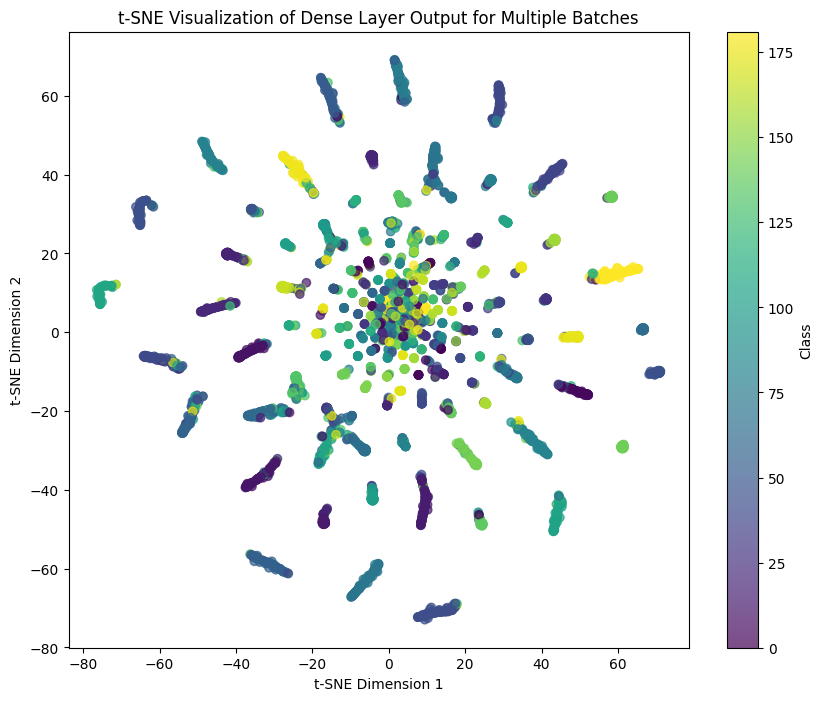

In [79]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


# Perform t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_results = tsne.fit_transform(features)
print("t-SNE results shape:", tsne_results.shape)  # Shape: (batch_size, 2)

# Visualize t-SNE results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=all_labels, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label="Class")
plt.title("t-SNE Visualization of Dense Layer Output for Multiple Batches")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()


There seems to just simply be too many classes and data points to infer anything useful about the model's learned feature for each class. Let's simply try to visualize just 10 classes

In [114]:
import numpy as np

# Specify the labels you want to visualize
desired_labels = [0,1,2,3,4,5,6,7,8,9]

# Create a mask for the desired labels
mask = np.isin(all_labels, desired_labels)

# Filter features and labels based on the mask
filtered_features = features[mask]
filtered_labels = all_labels[mask]


In [115]:
# Perform t-SNE on the filtered features
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_results = tsne.fit_transform(filtered_features)


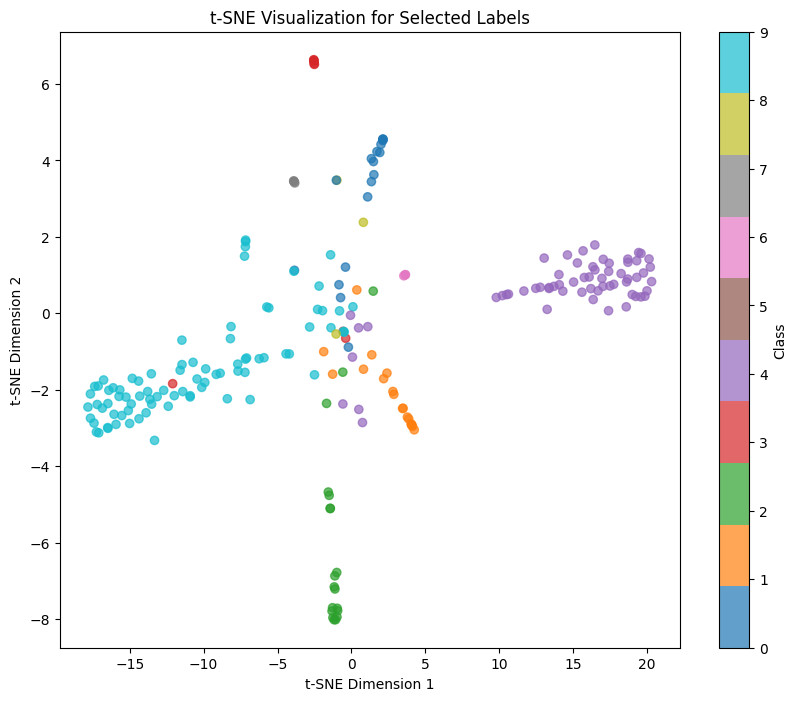

In [125]:
import matplotlib.pyplot as plt

# Visualize t-SNE results for the selected labels
plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=filtered_labels, cmap='tab10', alpha=0.7)
plt.colorbar(scatter, label="Class")
plt.title("t-SNE Visualization for Selected Labels")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()

Visualizing just 10 classes shows that the model is learning distinct features. In feature dimension 1 we see a stark difference between class 4 and 9 while in features dimension 2 we see a somewhat less stark but still quite noticable difference between class 0 and 2. Let's identify the species of these classes and attempt to identify the features on which the model is differentiating these species.

In [126]:
# First, let's confirm the labels we're using for tSNE match the validation dataframe
print(valid_labels[:4096]) # we only pulled 4096 images
print(all_labels)

[143  20 170 ...  77  10 177]
[143  20 170 ...  77  10 177]


In [136]:
# Now let's identify the species for classes 0, 2, 4, and 9
valid_df[valid_df['target'] == 0].head(1)

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename,filepath,target,xc_id
59,asbfly,['ashdro1'],"['adult', 'call', 'sex uncertain']",10.0825,78.2164,Muscicapa dauurica,Asian Brown Flycatcher,Sreekumar Chirukandoth,Creative Commons Attribution-NonCommercial-Sha...,4.5,http://xeno-canto.org/687954,XC687954.ogg,birdclef-2024/train_audio/asbfly/XC687954.ogg,0,XC687954


In [141]:
print(f"Class 0 Label: {valid_df[valid_df['target'] == 0].iloc[0]['primary_label']}, Species Name: {valid_df[valid_df['target'] == 0].iloc[0]['common_name']}")
print(f"Class 2 Label: {valid_df[valid_df['target'] == 2].iloc[0]['primary_label']}, Species Name: {valid_df[valid_df['target'] == 2].iloc[0]['common_name']}")
print(f"Class 4 Label: {valid_df[valid_df['target'] == 4].iloc[0]['primary_label']}, Species Name: {valid_df[valid_df['target'] == 4].iloc[0]['common_name']}")
print(f"Class 9 Label: {valid_df[valid_df['target'] == 9].iloc[0]['primary_label']}, Species Name: {valid_df[valid_df['target'] == 9].iloc[0]['common_name']}")

Class 0 Label: asbfly, Species Name: Asian Brown Flycatcher
Class 2 Label: ashpri1, Species Name: Ashy Prinia
Class 4 Label: asikoe2, Species Name: Asian Koel
Class 9 Label: barswa, Species Name: Barn Swallow


Now, let's attempt to discern the features by analyzing the differences in sounds between the Asian Brown Flycatcher and Ashy Prinia and the Asian Koel and Barn Swallow.